In [114]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import textwrap

In [115]:
df = pd.read_csv('datasets/output_30_binoculars_florian_prompt.csv', encoding='utf8')
df.columns

Index(['question', 'answer', 'question_answer_ai', 'answer_detection_score',
       'answer_detection_prediction', 'question_answer_ai_detection_score',
       'question_answer_ai_detection_prediction', 'id', 'prompt',
       'question_with_prompt', 'question_with_prompt_answer_ai',
       'question_with_prompt_answer_ai_detection_score',
       'question_with_prompt_answer_ai_detection_prediction'],
      dtype='object')

In [116]:
# Create list to store reorganized rows
reorganized_data = []

def normalize_label(label):
    """Convert various label formats to 'human' or 'ai'"""
    if pd.isna(label):
        return None
    label_lower = str(label).lower().strip()
    if 'human' in label_lower:
        return 'human'
    elif 'ai' in label_lower or 'generated' in label_lower:
        return 'ai'
    return None

# Group by question to handle duplicates
for question in df['question'].unique():
    question_data = df[df['question'] == question]
    
    # Human answer (first row, no prompt)
    human_row = question_data.iloc[0]
    reorganized_data.append({
        'question': human_row['question'],
        'answer': human_row['answer'],
        'prompt': '',
        'true_label': 'human',
        'predicted_label': normalize_label(human_row['answer_detection_prediction']),
        'score' : human_row['answer_detection_score']
    })
    
    # Regular AI answer (first row's AI answer, no prompt)
    reorganized_data.append({
        'question': human_row['question'],
        'answer': human_row['question_answer_ai'],
        'prompt': '',
        'true_label': 'ai',
        'predicted_label': normalize_label(human_row['question_answer_ai_detection_prediction']),
        'score' : human_row['question_answer_ai_detection_score']
    })
    
    # Prompted AI answers (one for each unique prompt)
    for _, row in question_data.iterrows():
        if pd.notna(row['prompt']) and row['prompt'] != '':
            reorganized_data.append({
                'question': row['question'],
                'answer': row['question_with_prompt_answer_ai'],
                'prompt': row['prompt'],
                'true_label': 'ai',
                'predicted_label': normalize_label(row['question_with_prompt_answer_ai_detection_prediction']),
                'score' : human_row['question_with_prompt_answer_ai_detection_score']
            })

# Create new dataframe
df_clean = pd.DataFrame(reorganized_data)

print(f"Original rows: {len(df)}")
print(f"Reorganized rows: {len(df_clean)}")
print("\nValue counts for true_label:")
print(df_clean['true_label'].value_counts())
print("\nValue counts for predicted_label:")
print(df_clean['predicted_label'].value_counts())
print("\nThe Dataframe itself:")
df_clean

Original rows: 60
Reorganized rows: 120

Value counts for true_label:
true_label
ai       90
human    30
Name: count, dtype: int64

Value counts for predicted_label:
predicted_label
ai       72
human    48
Name: count, dtype: int64

The Dataframe itself:


,question,answer,prompt,true_label,predicted_label,score
0,Postgresql allows adding comments to objects s...,All comments are stored in pg_description To g...,,human,human,0.926316
1,Postgresql allows adding comments to objects s...,To retrieve all tables along with their respec...,,ai,ai,0.767296
2,Postgresql allows adding comments to objects s...,To retrieve all tables along with their respec...,Aim for a Flesch Reading Ease score of 70 or h...,ai,ai,0.709184
3,Postgresql allows adding comments to objects s...,To get all tables along with their respective ...,Follow instructions: MANDATORY RULES: preserve...,ai,ai,0.709184
4,I was doing some work in scipy and a conversat...,Let the CDF $F$ equal $1-1/n$ at the integers ...,,human,human,0.985714
...,...,...,...,...,...,...
115,I have the following array: myarray = [ ['usa...,You loop through the array and create a hash f...,Follow instructions: MANDATORY RULES: preserve...,ai,ai,0.445076
116,"If I have a string, say, ""The quick brown fox ...","Here's how I would do it: >>> s = ""The quick b...",,human,human,0.986547
117,"If I have a string, say, ""The quick brown fox ...",You can achieve this in a more Pythonic way us...,,ai,ai,0.724638
118,"If I have a string, say, ""The quick brown fox ...","To improve readability and maintainability, we...",Aim for a Flesch Reading Ease score of 70 or h...,ai,ai,0.779762


In [ ]:
prompted = df_clean[(df_clean['true_label'] == 'ai') & (df_clean['prompt'] != '')]
predicted_ai = prompted[prompted['predicted_label'] == 'ai']
predicted_human = prompted[prompted['predicted_label'] == 'human']

# Get the 5 lowest scores in each predicted category
lowest_ai_scores = predicted_ai.nsmallest(5, 'score')
lowest_human_scores = predicted_human.nsmallest(5, 'score')

# Display results
print("Lowest 5 scores for predicted AI:")
print(lowest_ai_scores[['answer', 'score']])

print("\nLowest 5 scores for predicted Human:")
print(lowest_human_scores[['answer', 'score']])

Lowest 5 scores for predicted AI:
                                                prompt     score
114  Aim for a Flesch Reading Ease score of 70 or h...  0.445076
115  Follow instructions: MANDATORY RULES: preserve...  0.445076
58   Aim for a Flesch Reading Ease score of 70 or h...  0.542986
59   Follow instructions: MANDATORY RULES: preserve...  0.542986
106  Aim for a Flesch Reading Ease score of 70 or h...  0.546099

Lowest 5 scores for predicted Human:
                                               prompt     score
79  Follow instructions: MANDATORY RULES: preserve...  0.646789
75  Follow instructions: MANDATORY RULES: preserve...  0.754286
7   Follow instructions: MANDATORY RULES: preserve...  0.755639
47  Follow instructions: MANDATORY RULES: preserve...  0.759259
10  Aim for a Flesch Reading Ease score of 70 or h...  0.862676


In [117]:
human_answers = df_clean[df_clean['true_label'] == 'human']
regular_ai = df_clean[(df_clean['true_label'] == 'ai') & (df_clean['prompt'] == '')]

# Get individual prompts
unique_prompts = df_clean[df_clean['prompt'] != '']['prompt'].unique()

# Create groups dictionary with human and regular AI
groups = {
    'Human Answers': human_answers,
    'Regular AI (No Prompt)': regular_ai,
}

# Add each prompt as a separate group
for prompt in unique_prompts:
    prompt_df = df_clean[(df_clean['true_label'] == 'ai') & (df_clean['prompt'] == prompt)]
    groups[f'{prompt}'] = prompt_df

# Prepare a list to store results
results = []

for group_name, group_df in groups.items():
    if len(group_df) > 0:
        # Calculate accuracy
        correct = (group_df['true_label'] == group_df['predicted_label']).sum()
        accuracy = correct / len(group_df)

        # Confusion matrix values
        true_labels = group_df['true_label']
        pred_labels = group_df['predicted_label']

        tp = ((true_labels == 'human') & (pred_labels == 'human')).sum()
        fn = ((true_labels == 'human') & (pred_labels == 'ai')).sum()
        fp = ((true_labels == 'ai') & (pred_labels == 'human')).sum()
        tn = ((true_labels == 'ai') & (pred_labels == 'ai')).sum()

        # Calculate specific metrics
        if group_df['true_label'].iloc[0] == 'human':
            correct_human = (group_df['predicted_label'] == 'human').sum()
            results.append({
                'Group': group_name,
                'Sample Size': len(group_df),
                'Accuracy': accuracy,
                'True Positives (Human)': tp,
                'False Negatives (Human as AI)': fn,
                'Correctly Identified as Human': correct_human,
            })
        else:
            correct_ai = (group_df['predicted_label'] == 'ai').sum()
            fooled = (group_df['predicted_label'] == 'human').sum()
            results.append({
                'Group': group_name,
                'Sample Size': len(group_df),
                'Accuracy': accuracy,
                'True Negatives (AI)': tn,
                'False Positives (AI as Human)': fp,
                'Correctly Identified as AI': correct_ai,
                'Fooled Detector (Predicted as Human)': fooled,
            })

# Create DataFrame
results_df = pd.DataFrame(results)

# Calculate overall accuracy
overall_correct = (df_clean['true_label'] == df_clean['predicted_label']).sum()
overall_accuracy = overall_correct / len(df_clean)

# Add overall accuracy to DataFrame
overall_row = {
    'Group': 'Overall',
    'Sample Size': len(df_clean),
    'Accuracy': overall_accuracy,
}
results_df = pd.concat([results_df, pd.DataFrame([overall_row])], ignore_index=True)

# Compare prompted vs unprompted AI (aggregate all prompts)
prompted_ai_all = df_clean[(df_clean['true_label'] == 'ai') & (df_clean['prompt'] != '')]
if len(regular_ai) > 0 and len(prompted_ai_all) > 0:
    regular_detected = (regular_ai['predicted_label'] == 'ai').sum() / len(regular_ai)
    prompted_detected = (prompted_ai_all['predicted_label'] == 'ai').sum() / len(prompted_ai_all)
    reduction = regular_detected - prompted_detected
    improvement_pct = ((reduction) / regular_detected * 100) if regular_detected > 0 else 0

    prompt_effect_row = {
        'Group': 'Prompt Effectiveness (Aggregate)',
        'Regular AI Detected as AI': f"{regular_detected:.2%}",
        'Prompted AI Detected as AI': f"{prompted_detected:.2%}",
        'Reduction in Detection Rate': f"{reduction:.2%}",
        'Prompts Improved Evasion by': f"{improvement_pct:.1f}%",
    }
    prompt_effect_df = pd.DataFrame([prompt_effect_row])

# Display the DataFrames
print("Accuracy and Confusion Matrix Results:")
print(results_df[['Group', 'Sample Size', 'Accuracy']].to_string(index=False))

print("\nPrompt Effectiveness Analysis:")
print(prompt_effect_df.to_string(index=False))

human_answers[['question', 'answer']]

Accuracy and Confusion Matrix Results:
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         Group  Sample Size  Accuracy
                                                                                                                                                                                                                                                                                                                           

,question,answer
0,Postgresql allows adding comments to objects s...,All comments are stored in pg_description To g...
4,I was doing some work in scipy and a conversat...,Let the CDF $F$ equal $1-1/n$ at the integers ...
8,Can a permutation matrix ($P$) be used to chan...,Hint: The rank of a matrix is the number of li...
12,Is there any way to find out what I just kille...,"There is no general way to know, but you may h..."
16,"In my SQL Server backend for my app, I want to...",Triggers. We wrote a GUI (internally called Re...
20,Possible Duplicate: Is destructor called if SI...,"With difficulty. Already, the code you've wri..."
24,What is the second line? (Seen while answerin...,It's placement new . It constructs a new int ...
28,"Consider the following snippet: ""12-18"" -Conta...",The -Contains operator doesn't do substring co...
32,"The force density in a plasma, according to MH...",I think the easiest way is to start off with t...
36,"I work in web development, but I don't have a ...","Since I asked this question, I've learned more..."


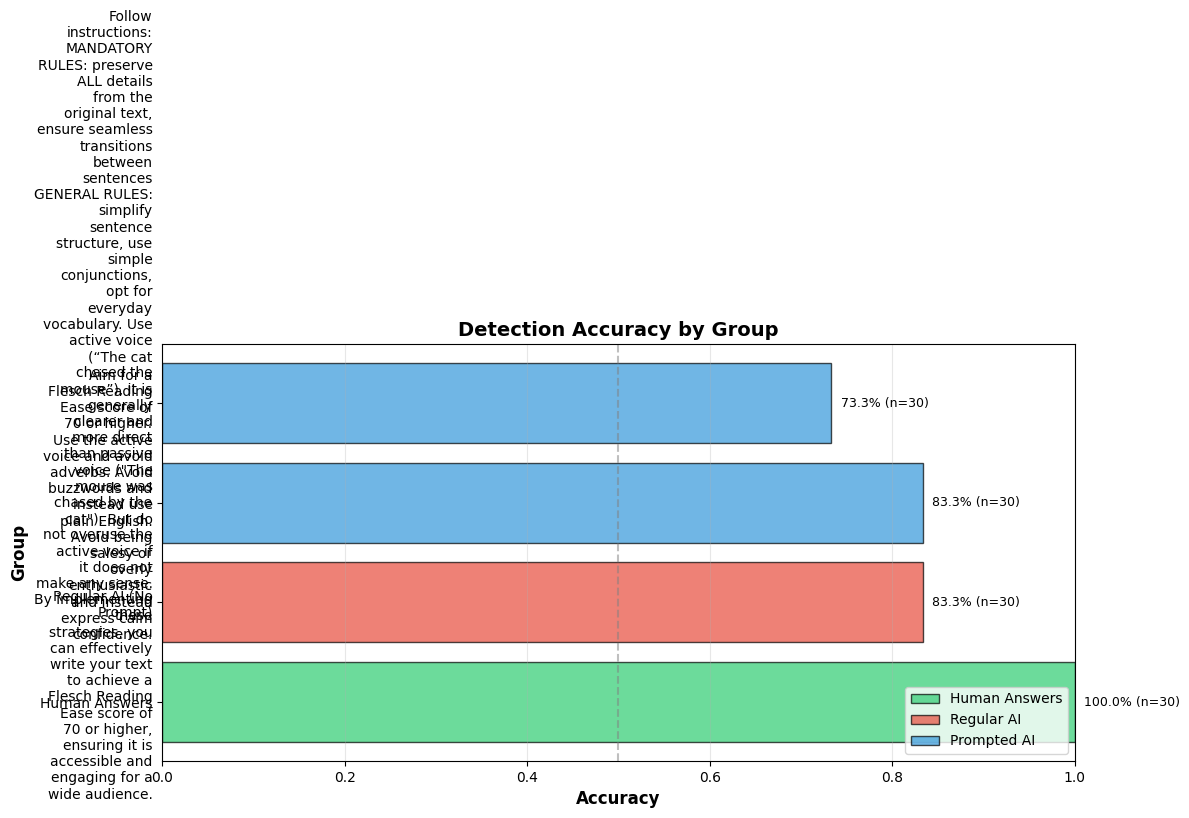

In [118]:


# Filter out the 'Overall' row for the main visualization
results_plot = results_df[results_df['Group'] != 'Overall'].copy()

# Extract data for plotting
groups = results_plot['Group'].tolist()
accuracies = results_plot['Accuracy'].tolist()
sample_sizes = results_plot['Sample Size'].tolist()

# Create color mapping
colors = []
for group in groups:
    if 'Human' in group:
        colors.append('#2ecc71')  # Green for human
    elif 'Regular AI' in group:
        colors.append('#e74c3c')  # Red for regular AI
    else:
        colors.append('#3498db')  # Blue for prompted AI

# Wrap y-axis labels
wrapped_groups = [textwrap.fill(group, width=15) for group in groups]

# Create the plot
fig, ax = plt.subplots(figsize=(12, 8))

# Create horizontal bar chart (categories on y-axis)
bars = ax.barh(wrapped_groups, accuracies, color=colors, alpha=0.7, edgecolor='black')

# Customize the plot
ax.set_xlabel('Accuracy', fontsize=12, fontweight='bold')
ax.set_ylabel('Group', fontsize=12, fontweight='bold')
ax.set_title('Detection Accuracy by Group', fontsize=14, fontweight='bold')
ax.set_xlim(0.0, 1.0)
ax.axvline(x=0.5, color='gray', linestyle='--', alpha=0.5, label='Random Baseline (50%)')
ax.grid(axis='x', alpha=0.3)

# Add value labels on the right of bars
for i, (bar, acc, size) in enumerate(zip(bars, accuracies, sample_sizes)):
    width = bar.get_width()
    ax.text(width + 0.01,  # x position (end of the bar)
            bar.get_y() + bar.get_height()/2.0,  # y position (middle of the bar)
            f'{acc:.1%} (n={size})',
            ha='left', va='center', fontsize=9)

# Add legend
from matplotlib.patches import Patch
legend_elements = [
    Patch(facecolor='#2ecc71', alpha=0.7, edgecolor='black', label='Human Answers'),
    Patch(facecolor='#e74c3c', alpha=0.7, edgecolor='black', label='Regular AI'),
    Patch(facecolor='#3498db', alpha=0.7, edgecolor='black', label='Prompted AI')
]
ax.legend(handles=legend_elements, loc='lower right')

plt.tight_layout()
plt.show()
